In [1]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -qq val2017.zip
!git clone --depth 1 https://github.com/tensorflow/models
!rm val2017.zip

--2022-12-23 15:07:38--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.140.124, 52.217.228.1, 54.231.225.137, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.140.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  12.7MB/s    in 64s     

2022-12-23 15:08:43 (12.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

Cloning into 'models'...
remote: Enumerating objects: 3631, done.
remote: Counting objects: 100% (3631/3631), done.
remote: Compressing objects: 100% (3027/3027), done.
remote: Total 3631 (delta 959), reused 1533 (delta 549), pack-reused 0
Receiving objects: 100% (3631/3631), 47.13 MiB | 15.17 MiB/s, done.
Resolving deltas: 100% (959/959), done.


In [2]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696474 sha256=d627c8dd3ce3b4c94119b557828c6158f72efdfcfd44c7b68e1bac1d456024b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-etzo5yb_/wheels/7d/96/c1/072a751379735e8dfdada1def1c62a89afb3cc45654fd6fd28
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=00c3c3bc51f9dc40968b4aff68026ee5140e467c710741a2564b31f423da9b21
  Stored in directory: /root/.cache/pip/wheels/07/35/78/e9004fa30578734db7f10e7a211605f3f0778d2bdde38a239d
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44009 sha256=e397e815431e4a1edf455e0f116de8435b4caac4802c6c791e099ca3ccb0ab8d
  Stored in directory: /root/.cache/pip/wheels/bb/73/e9/d273421f5723c4bf544dcf9eb097bda94421ef8d3252699f0a
  Created wheel for docopt: filename=docopt-

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import os

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import gc

%matplotlib inline

In [4]:
MODELS = {'ssd_resnet': 'ssd_resnet152_v1_fpn_640x640_coco17_tpu-8', 'rcnn': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8', 'mobile_net': 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8'}
RESIZE_SHAPES = {'ssd_resnet': (640, 640), 'rcnn': (640, 640), 'mobile_net': (640, 640)}
model_display_name = 'rcnn' # @param ['ssd_resnet', 'rcnn', 'mobile_net']
model_name = MODELS[model_display_name]
model_resize_shape = RESIZE_SHAPES[model_display_name]
model_height, model_width = model_resize_shape

In [5]:
if model_display_name == 'ssd_resnet':
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !tar -xf ssd_resnet152_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !mv ssd_resnet152_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
elif model_display_name == 'mobile_net':
    # ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !tar -xf ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !mv ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
else:
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
    !tar -xf faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
    !mv faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
!rm -rf *.tar.gz

--2022-12-23 15:10:32--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.12.128, 2404:6800:4003:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.12.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353643040 (337M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet1 100%[===================>] 337.26M  64.7MB/s    in 5.2s    

2022-12-23 15:10:38 (64.7 MB/s) - ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz’ saved [353643040/353643040]



In [6]:
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
                                model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [7]:
# label_map_path = configs['eval_input_config'].label_map_path

label_id_offset = 1

coco_label_map_path = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

coco_label_map = label_map_util.load_labelmap(coco_label_map_path)
coco_categories = label_map_util.convert_label_map_to_categories(
    coco_label_map,
    max_num_classes=label_map_util.get_max_label_map_index(coco_label_map),
    use_display_name=True)
coco_category_index = label_map_util.create_category_index(coco_categories)
coco_label_map_dict = label_map_util.get_label_map_dict(coco_label_map, use_display_name=True)

# Load Annotations

In [8]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq annotations_trainval2017.zip
!rm annotations_trainval2017.zip

--2022-12-23 15:10:47--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.231.121, 54.231.161.209, 54.231.198.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.231.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  13.3MB/s    in 20s     

2022-12-23 15:11:07 (11.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [9]:
import json
annotations_file = open('annotations/instances_val2017.json')
val_annotations = json.load(annotations_file)
annotations_file.close()

In [10]:
from collections import defaultdict
gt_category_ids = defaultdict(list)
gt_bboxes = defaultdict(list)
gt_shapes = {}
image_ids_to_filename = {}

for image_details in val_annotations['images']:
    img_file_name = image_details['file_name']
    gt_shapes[img_file_name] = (image_details['height'], image_details['width'])

    img_id = image_details['id']
    image_ids_to_filename[img_id] = img_file_name

for annotation in val_annotations['annotations']:
    img_id = annotation['image_id']
    img_file_name = image_ids_to_filename[img_id]
    original_height, original_width = gt_shapes[img_file_name]
    img_category_id = annotation['category_id']
    x, y, w, h = annotation['bbox']
    box = [y/original_height, x/original_width, (y+h)/original_height, (x+w)/original_width]
    
    gt_category_ids[img_file_name].append(img_category_id)
    gt_bboxes[img_file_name].append(box)
    # gt_bboxes[img_file_name].append(annotation['bbox'])


for key in gt_bboxes.keys():
    gt_bboxes[key] = np.array(gt_bboxes[key])

for key in gt_category_ids.keys():
    gt_category_ids[key] = np.array(gt_category_ids[key])

# Load Dataset

In [11]:
from PIL import Image

def load_one_image(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return np.array(img)

def load_images(img_paths, resize_shape=(640, 640)):
    arr = []

    for path in img_paths:
        pil_img = Image.open(path)
        if pil_img.mode != 'RGB':
            pil_img = pil_img.convert('RGB')
        arr.append(np.array(pil_img.resize(resize_shape)))
    return np.array(arr)


In [12]:
import glob
loaded_images_num = -1          # for testing
images_paths = glob.glob('val2017/*')[:loaded_images_num]

In [13]:
score_thresh = 0.5

In [14]:
import gc

def train_batch(batch_paths, image_detections_dict):
    images_np = load_images(batch_paths, model_resize_shape)
    input_tensor = tf.convert_to_tensor(images_np, dtype=tf.float32)
    del images_np
    gc.collect()
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    for i, path in enumerate(batch_paths):
        boxes = detections['detection_boxes'][i].numpy()
        scores = detections['detection_scores'][i].numpy()
        classes = detections['detection_classes'][i].numpy().astype(int) + label_id_offset

        # considered_indices = np.where(scores >= score_thresh)

        # boxes = boxes[considered_indices]
        # scores = scores[considered_indices]
        # classes = classes[considered_indices]

        if len(boxes) == 0:
            continue

        image_detections_dict[path.split('/')[-1]] = {
            'boxes': boxes,
            'scores': scores, 
            'classes': classes}    

In [15]:
image_detections_dict = {}
gc.collect()

0

In [16]:
batch_size = 1

images_num = len(images_paths)
# images_num = 1000


for batch_start_idx in range(0, images_num, batch_size):
    batch_paths = images_paths[batch_start_idx: min(batch_start_idx+batch_size, images_num)]
    train_batch(batch_paths, image_detections_dict)
    
    print(f"{batch_start_idx+batch_size} have been processed")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use ref() instead.


1 have been processed
2 have been processed
3 have been processed
4 have been processed
5 have been processed
6 have been processed
7 have been processed
8 have been processed
9 have been processed
10 have been processed
11 have been processed
12 have been processed
13 have been processed
14 have been processed
15 have been processed
16 have been processed
17 have been processed
18 have been processed
19 have been processed
20 have been processed
21 have been processed
22 have been processed
23 have been processed
24 have been processed
25 have been processed
26 have been processed
27 have been processed
28 have been processed
29 have been processed
30 have been processed
31 have been processed
32 have been processed
33 have been processed
34 have been processed
35 have been processed
36 have been processed
37 have been processed
38 have been processed
39 have been processed
40 have been processed
41 have been processed
42 have been processed
43 have been processed
44 have been process

# Visualize One Image

In [17]:
def get_gt_detections_pair(test_img_path):
    test_img_name = test_img_path.split('/')[-1]

    test_img_with_detections = load_one_image(test_img_path)
    gt_img_with_detections = test_img_with_detections.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        test_img_with_detections,
        image_detections_dict[test_img_name]['boxes'],
        image_detections_dict[test_img_name]['classes'],
        image_detections_dict[test_img_name]['scores'],
        coco_category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=score_thresh,
        agnostic_mode=False)

    viz_utils.visualize_boxes_and_labels_on_image_array(
        gt_img_with_detections,
        gt_bboxes[test_img_name],
        gt_category_ids[test_img_name],
        np.ones_like(gt_category_ids[test_img_name]),
        coco_category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=score_thresh,
        agnostic_mode=False)
    return gt_img_with_detections, test_img_with_detections


def print_bbox_gt_detections_pair(gt, detections, mAP=0):
    plt.figure(figsize=(24,16))
    plt.subplot(121)
    plt.title("Ground Truth")
    plt.imshow(gt)

    plt.subplot(122)
    plt.title(f"Detections, mAP: {mAP}")
    plt.imshow(detections)
    plt.show()

In [18]:
from object_detection.metrics import coco_evaluation
from object_detection.core import standard_fields

In [19]:
def add_single_img_to_evaluator(coco_evaluator, file_name, image_detections_dict, gt_bboxes, gt_category_ids):
    if len(gt_category_ids[file_name]) == 0 or not file_name in image_detections_dict:
        return
    coco_evaluator.add_single_ground_truth_image_info(
        image_id=file_name,
        groundtruth_dict={
            standard_fields.InputDataFields.groundtruth_boxes: gt_bboxes[file_name],
            standard_fields.InputDataFields.groundtruth_classes: gt_category_ids[file_name]
        }
    )

    coco_evaluator.add_single_detected_image_info(
        image_id=file_name,
        detections_dict={
            standard_fields.DetectionResultFields.detection_boxes: image_detections_dict[file_name]['boxes'],
            standard_fields.DetectionResultFields.detection_classes: image_detections_dict[file_name]['classes'],
            standard_fields.DetectionResultFields.detection_scores: image_detections_dict[file_name]['scores']
        }
    )    
    

In [20]:
coco_evaluator = coco_evaluation.CocoDetectionEvaluator(coco_categories)

for name in list(image_detections_dict.keys()):
    add_single_img_to_evaluator(coco_evaluator, name, image_detections_dict, gt_bboxes, gt_category_ids)

print(coco_evaluator.evaluate())
coco_evaluator.clear()

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=106.08s).
Accumulating evaluation results...
DONE (t=20.85s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.46

In [21]:
def get_img_metrics(img_metrics, file_name, image_detections_dict, gt_bboxes, gt_category_ids):
    if len(gt_category_ids[file_name]) == 0 or not file_name in image_detections_dict:
        return
    coco_evaluator = coco_evaluation.CocoDetectionEvaluator(coco_categories)
    coco_evaluator.add_single_ground_truth_image_info(
        image_id=file_name,
        groundtruth_dict={
            standard_fields.InputDataFields.groundtruth_boxes: gt_bboxes[file_name],
            standard_fields.InputDataFields.groundtruth_classes: gt_category_ids[file_name]
        }
    )

    coco_evaluator.add_single_detected_image_info(
        image_id=file_name,
        detections_dict={
            standard_fields.DetectionResultFields.detection_boxes: image_detections_dict[file_name]['boxes'],
            standard_fields.DetectionResultFields.detection_classes: image_detections_dict[file_name]['classes'],
            standard_fields.DetectionResultFields.detection_scores: image_detections_dict[file_name]['scores']
        }
    )

    metrics = coco_evaluator.evaluate()
    img_metrics[file_name] = metrics['DetectionBoxes_Precision/mAP']


In [ ]:
img_metrics = {}

for name in list(image_detections_dict.keys()):
    get_img_metrics(img_metrics, name, image_detections_dict, gt_bboxes, gt_category_ids)


Streaming output truncated to the last 5000 lines.
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000

In [ ]:
sorted_img_metrics = dict(sorted(img_metrics.items(), key=lambda item: item[1]))

# Bad Examples

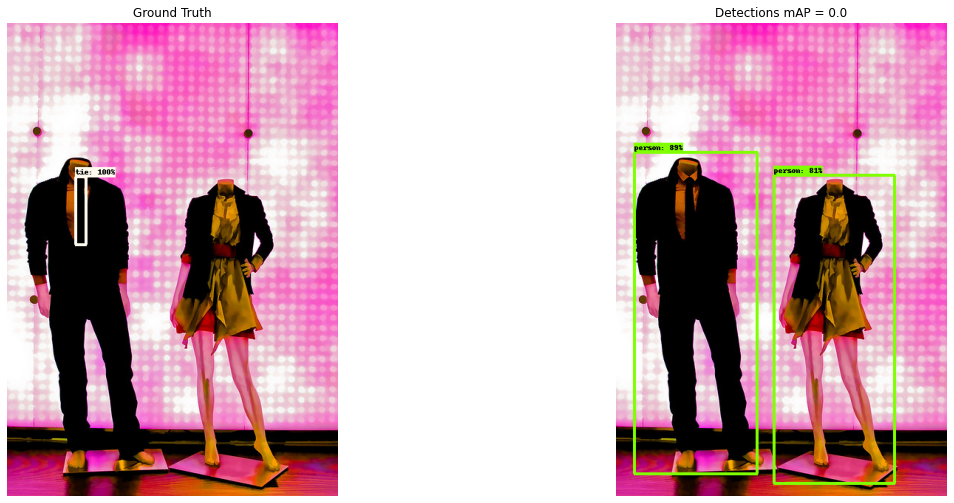

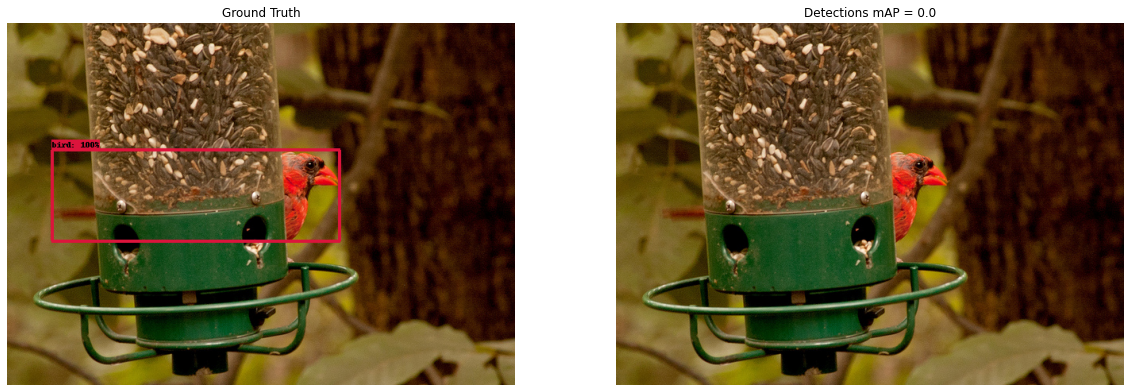

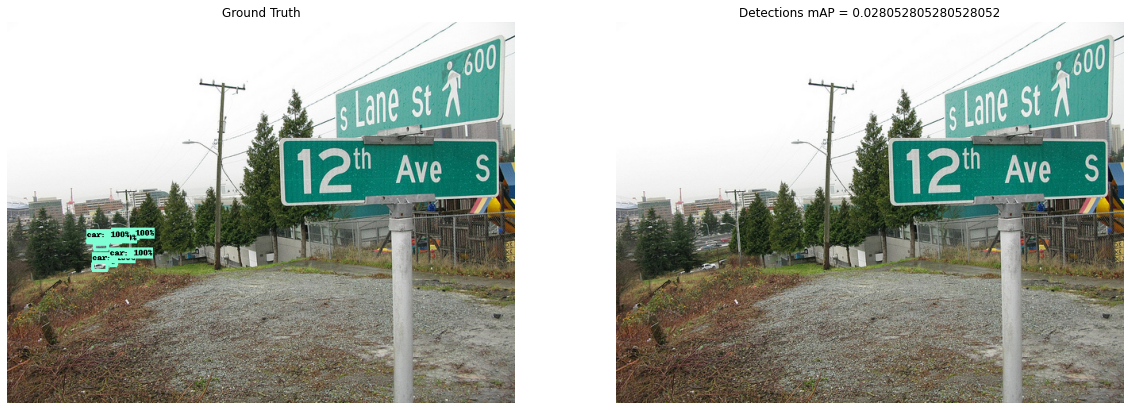

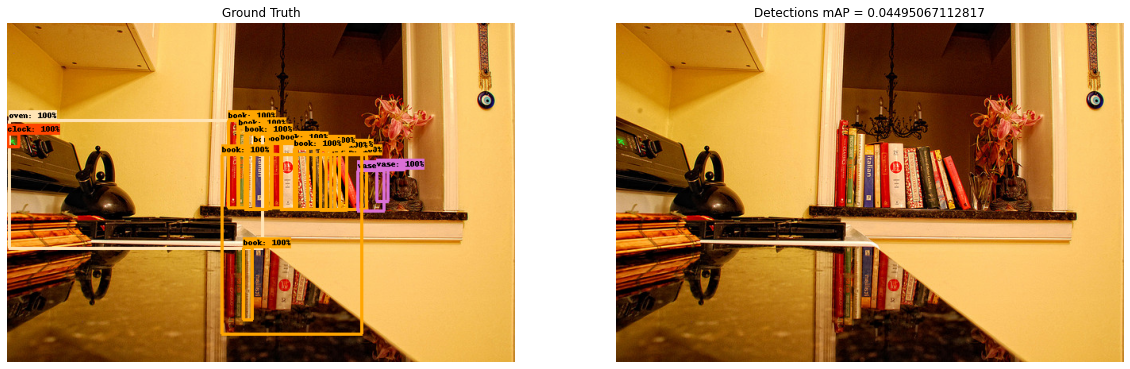

In [ ]:
for i in range(4):
    name = list(sorted_img_metrics.keys())[i*4]
    mAP = list(sorted_img_metrics.values())[i*4]

    gt, detections = get_gt_detections_pair(f'val2017/{name}')

    plt.figure(figsize=(20, 40))
    plt.subplot(4, 2, 2*i+1)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(gt)

    plt.subplot(4, 2, 2*i+2)
    plt.title(f'Detections mAP = {mAP}')
    plt.axis('off')
    plt.imshow(detections)
plt.show()

# Good Examples

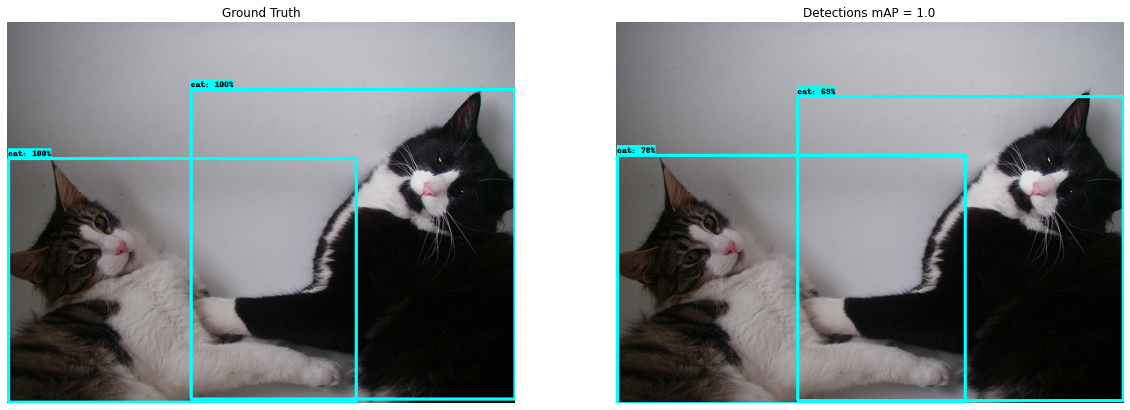

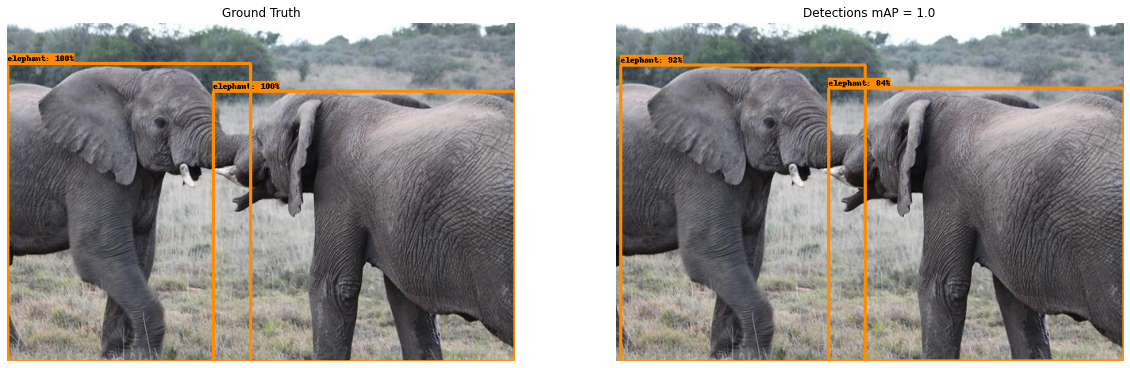

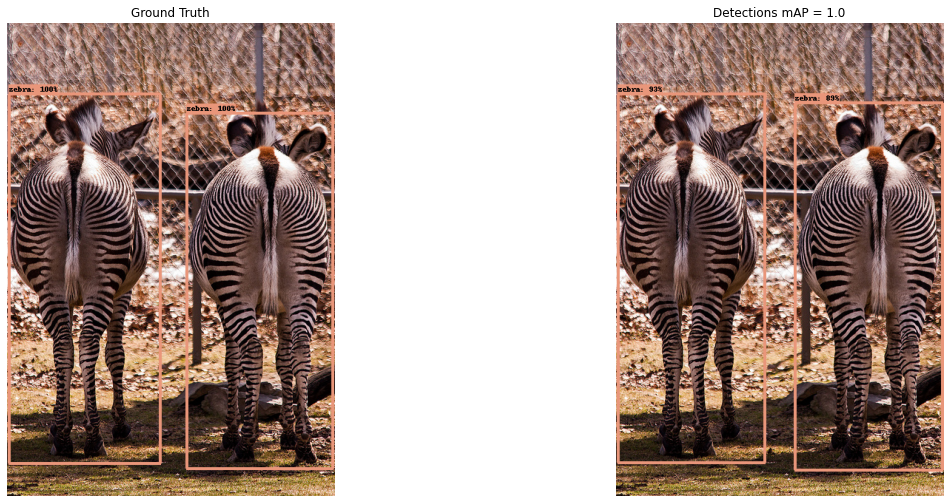

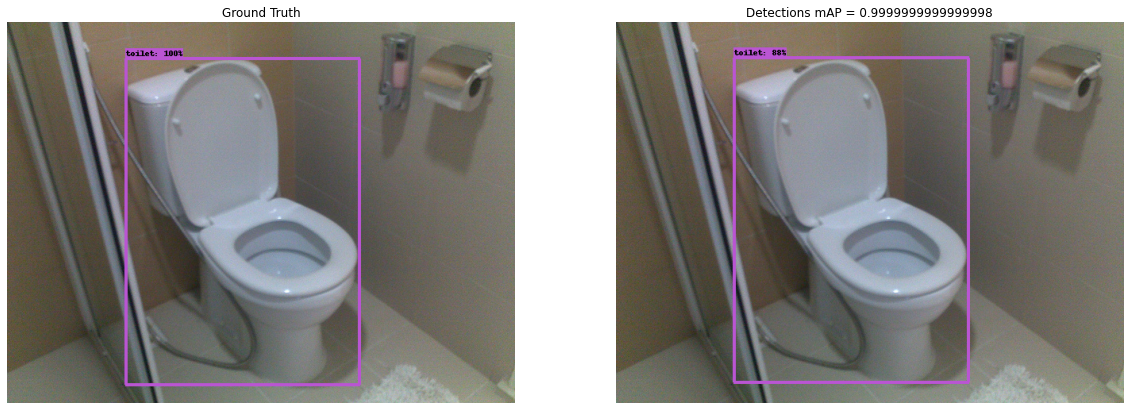

In [ ]:
for i in range(4):
    name = list(sorted_img_metrics.keys())[-(i*4+1)]
    mAP = list(sorted_img_metrics.values())[-(i*4+1)]

    gt, detections = get_gt_detections_pair(f'val2017/{name}')

    plt.figure(figsize=(20, 40))
    plt.subplot(4, 2, 2*i+1)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(gt)

    plt.subplot(4, 2, 2*i+2)
    plt.title(f'Detections mAP = {mAP}')
    plt.axis('off')
    plt.imshow(detections)
plt.show()

# Pascal Voc Dataset
## Download dataset

In [ ]:
import tensorflow_datasets as tfds

voc = tfds.object_detection.Voc()

In [ ]:
voc.download_and_prepare()

In [ ]:
pascal_label_map_path = 'models/research/object_detection/data/pascal_label_map.pbtxt'
label_id_offset = 1

pascal_label_map = label_map_util.load_labelmap(pascal_label_map_path)
pascal_categories = label_map_util.convert_label_map_to_categories(
    pascal_label_map,
    max_num_classes=label_map_util.get_max_label_map_index(pascal_label_map),
    use_display_name=True)
pascal_category_index = label_map_util.create_category_index(pascal_categories)
pascal_label_map_dict = {}

In [ ]:
pascal_label_map_dict = {}

for element in pascal_categories:
    name = element['name']
    pascal_id = element['id']

    if not name in coco_label_map_dict:
        continue
    coco_id = coco_label_map_dict[name]

    pascal_label_map_dict[pascal_id] = coco_id
print(pascal_label_map_dict)

{2: 2, 3: 16, 4: 9, 5: 44, 6: 6, 7: 3, 8: 17, 9: 62, 10: 21, 12: 18, 13: 19, 15: 1, 17: 20, 19: 7}


In [ ]:
import cv2
pascal_images = []
pascal_gt_boxes = {}
pascal_gt_category_ids = {}

pascal_image_names = []

for element in voc.as_dataset()['validation'].as_numpy_iterator():
    image_name = element['image/filename']
    pascal_image_names.append(image_name)
    image = element['image']
    image = cv2.resize(image, model_resize_shape)

    bbox = element['objects']['bbox']
    labels = element['objects']['label'] + label_id_offset

    selected_indices = []

    for i in range(len(labels)):
        if not labels[i] in pascal_label_map_dict:
            continue
        labels[i] = pascal_label_map_dict[labels[i]]
        selected_indices.append(i)

    bbox = bbox[selected_indices]
    labels = labels[selected_indices]

    pascal_images.append(image)
    pascal_gt_boxes[image_name] = bbox
    pascal_gt_category_ids[image_name] = labels

pascal_images = np.array(pascal_images)
gc.collect()

0

In [ ]:
pascal_img_name_to_idx = {img_name: i for i, img_name in enumerate(pascal_image_names)}

In [ ]:
# def load_pascal_batch(batch_start_idx, batch_size):
#     arr = []
#     paths = []

#     for i, element in enumerate(dataset.skip(batch_start_idx).as_numpy_iterator()):
#         image = element['image']
#         image = cv2.resize(image, model_resize_shape)
#         arr.append(image)
#         paths.append(element['image/filename'])

#         if i >= batch_size:
#             break
#     return np.array(arr), paths

def infer_pascal_batch(images_np, batch_paths, pascal_image_detections_dict, batch_start_idx, batch_size):
    # images_np, batch_paths = load_pascal_batch(dataset, batch_start_idx, batch_size)
    input_tensor = tf.convert_to_tensor(images_np, dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    for i, path in enumerate(batch_paths):
        boxes = detections['detection_boxes'][i].numpy()
        scores = detections['detection_scores'][i].numpy()
        classes = detections['detection_classes'][i].numpy().astype(int) + label_id_offset

        selected_indices = []

        for i in range(len(classes)):
            if not classes[i] in pascal_label_map_dict.values():
                continue
            selected_indices.append(i)

        boxes = boxes[selected_indices]
        scores = scores[selected_indices]
        classes = classes[selected_indices]

        if len(boxes) == 0:
            continue

        pascal_image_detections_dict[path] = {
            'boxes': boxes,
            'scores': scores, 
            'classes': classes}    

In [ ]:
pascal_image_detections_dict = {}

In [ ]:
batch_size = 10

# images_num = 100
images_num = len(voc.as_dataset()['validation'])

for i in range(0, images_num, batch_size):
    infer_pascal_batch(pascal_images[i: i + batch_size], pascal_image_names[i: i + batch_size], pascal_image_detections_dict, i, batch_size)
    print(f'{i + batch_size} images have been processed')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


10 images have been processed
20 images have been processed
30 images have been processed
40 images have been processed
50 images have been processed
60 images have been processed
70 images have been processed
80 images have been processed
90 images have been processed
100 images have been processed
110 images have been processed
120 images have been processed
130 images have been processed
140 images have been processed
150 images have been processed
160 images have been processed
170 images have been processed
180 images have been processed
190 images have been processed
200 images have been processed
210 images have been processed
220 images have been processed
230 images have been processed
240 images have been processed
250 images have been processed
260 images have been processed
270 images have been processed
280 images have been processed
290 images have been processed
300 images have been processed
310 images have been processed
320 images have been processed
330 images have b

In [ ]:
def pascal_get_gt_detections_pair(test_img_name, score_thresh = 0.5):
    test_img_idx = pascal_img_name_to_idx[test_img_name]

    print(pascal_gt_category_ids[test_img_name])
    print(pascal_image_detections_dict[test_img_name]['classes'][np.where(pascal_image_detections_dict[test_img_name]['scores'] >= score_thresh)])

    test_img_with_detections = pascal_images[test_img_idx].copy()
    gt_img_with_detections = test_img_with_detections.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        test_img_with_detections,
        pascal_image_detections_dict[test_img_name]['boxes'],
        pascal_image_detections_dict[test_img_name]['classes'],
        pascal_image_detections_dict[test_img_name]['scores'],
        coco_category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=score_thresh,
        agnostic_mode=False)

    viz_utils.visualize_boxes_and_labels_on_image_array(
        gt_img_with_detections,
        pascal_gt_boxes[test_img_name],
        pascal_gt_category_ids[test_img_name],
        np.ones_like(pascal_gt_category_ids[test_img_name]),
        coco_category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=score_thresh,
        agnostic_mode=False)
    return gt_img_with_detections, test_img_with_detections


In [ ]:
from object_detection.metrics import coco_evaluation
from object_detection.core import standard_fields

In [ ]:
coco_evaluator = coco_evaluation.CocoDetectionEvaluator(coco_categories)

for name in pascal_image_names:
    add_single_img_to_evaluator(coco_evaluator, name, pascal_image_detections_dict, pascal_gt_boxes, pascal_gt_category_ids)

print(coco_evaluator.evaluate())
coco_evaluator.clear()

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.59s).
Accumulating evaluation results...
DONE (t=1.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.819
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711


In [ ]:
pascal_img_metrics = {}

for name in pascal_image_names:
    get_img_metrics(pascal_img_metrics, name, pascal_image_detections_dict, pascal_gt_boxes, pascal_gt_category_ids)


Streaming output truncated to the last 5000 lines.
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.450
 Average Recall     (AR) @[ 

In [ ]:
pascal_sorted_img_metrics = dict(sorted(pascal_img_metrics.items(), key=lambda item: item[1]))

# Bad Examples

[1]
[]
[19]
[]
[3]
[]
[9]
[]


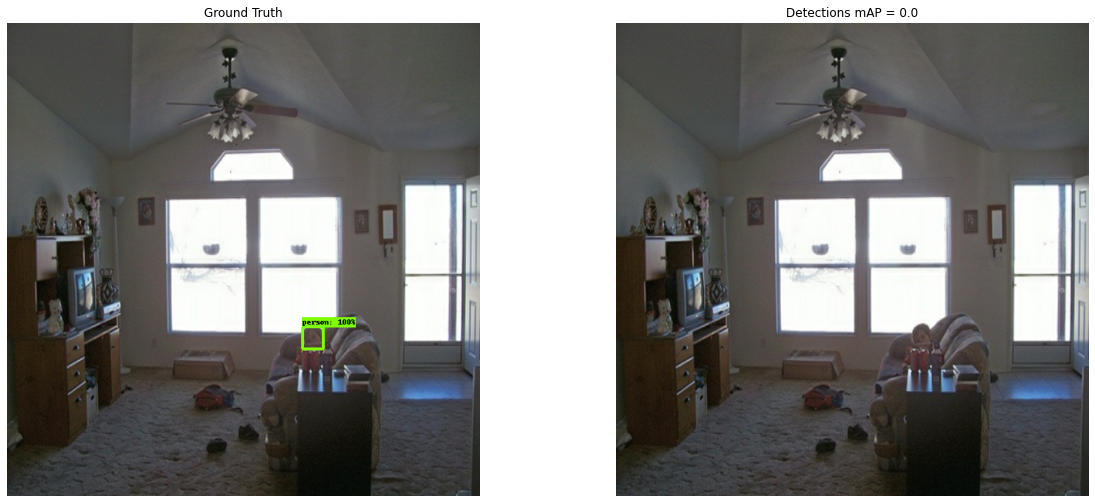

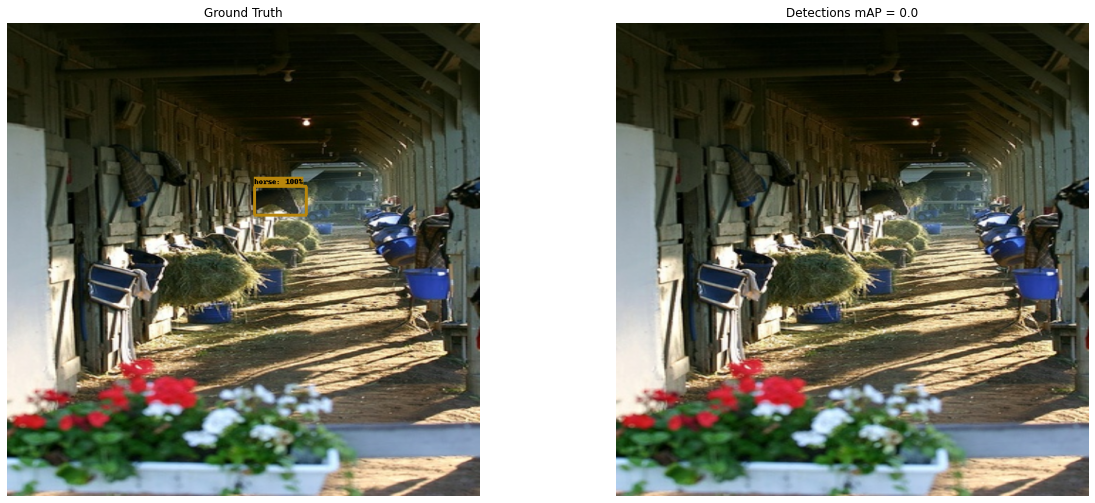

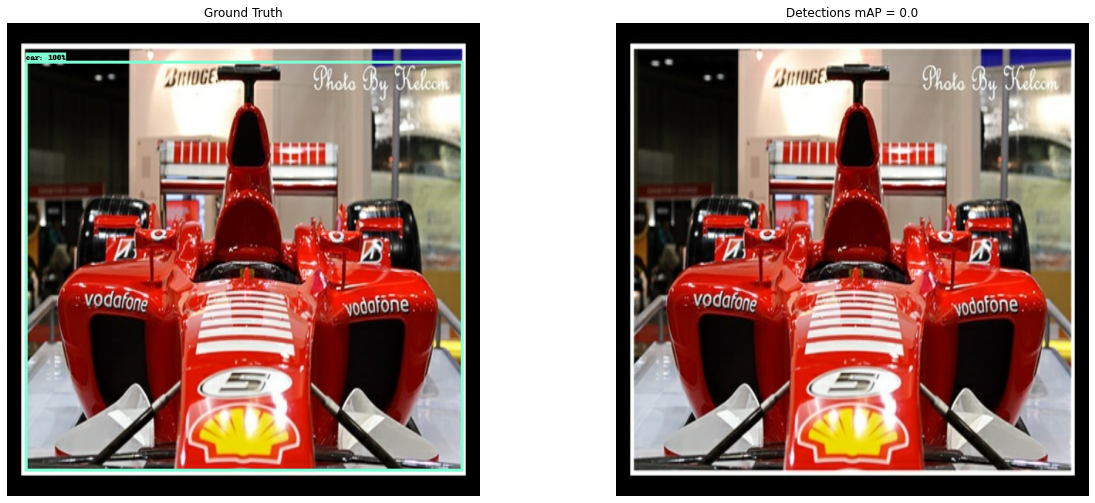

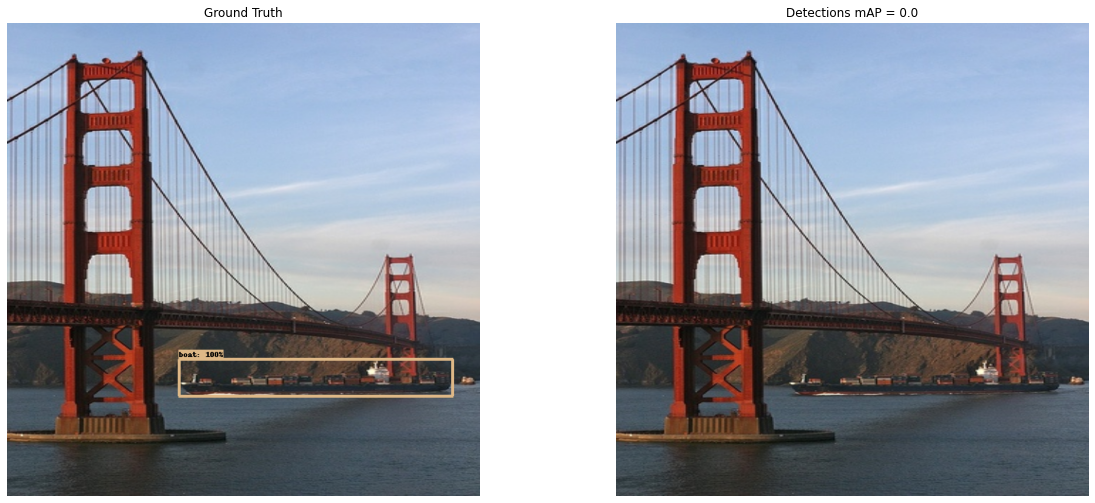

In [ ]:
for i in range(4):
    name = list(pascal_sorted_img_metrics.keys())[i]
    mAP = list(pascal_sorted_img_metrics.values())[i]

    gt, detections = pascal_get_gt_detections_pair(name)

    plt.figure(figsize=(20, 40))
    plt.subplot(4, 2, 2*i+1)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(gt)

    plt.subplot(4, 2, 2*i+2)
    plt.title(f'Detections mAP = {mAP}')
    plt.axis('off')
    plt.imshow(detections)
plt.show()

# Good Examples

[1 1]
[1 1]
[16 16]
[16 16]
[18 18]
[18 18]
[1 1]
[1 1]


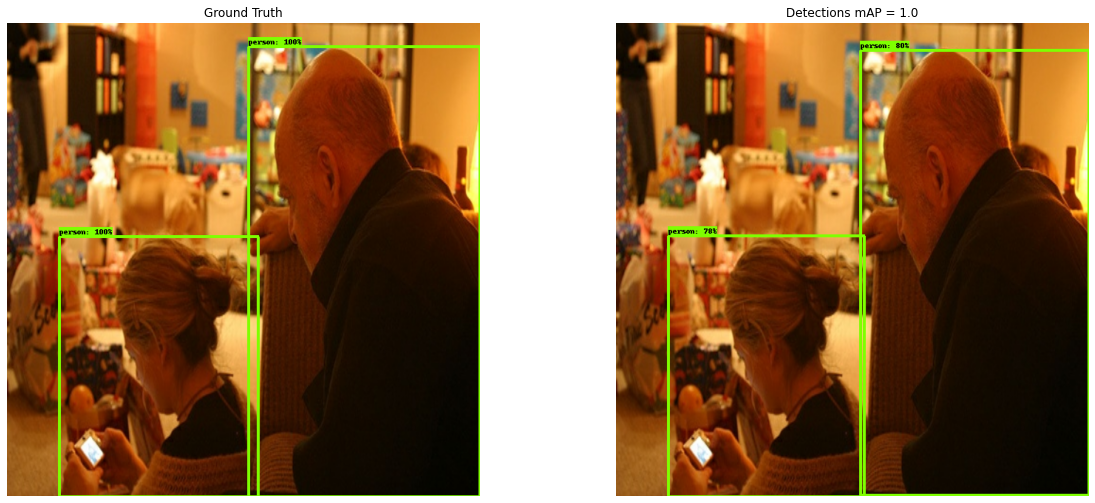

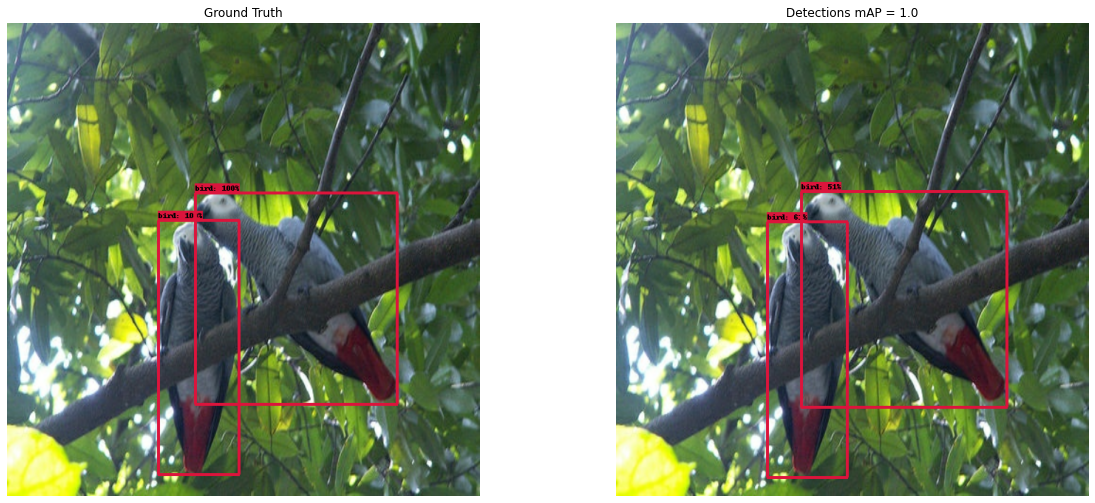

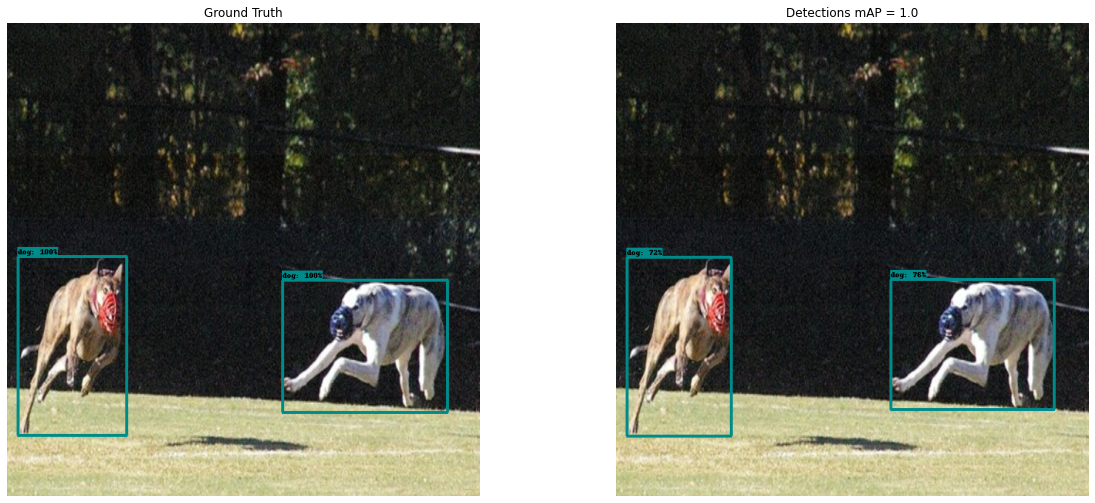

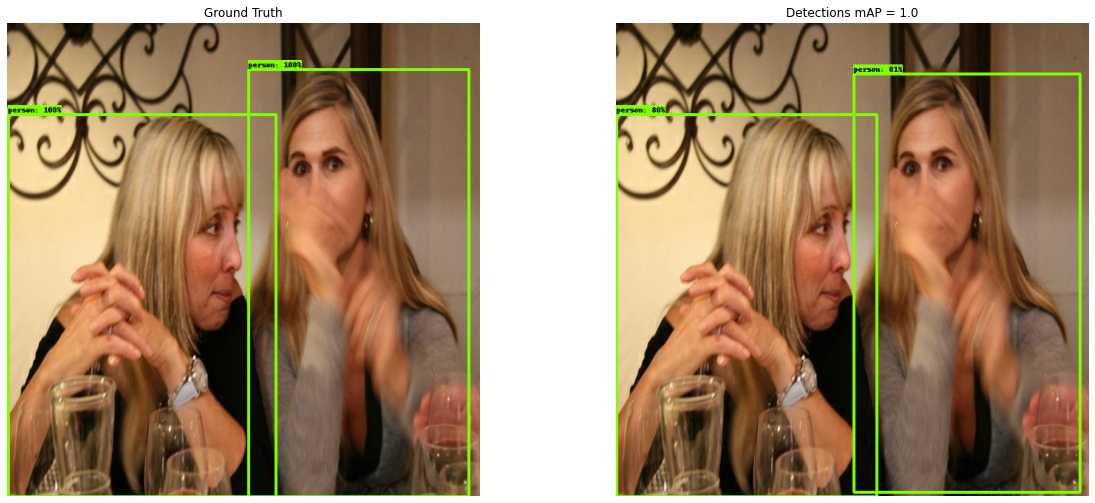

In [ ]:
for i in range(4):
    name = list(pascal_sorted_img_metrics.keys())[-(i+1)]
    mAP = list(pascal_sorted_img_metrics.values())[-(i+1)]

    gt, detections = pascal_get_gt_detections_pair(name, 0.5)

    plt.figure(figsize=(20, 40))
    plt.subplot(4, 2, 2*i+1)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(gt)

    plt.subplot(4, 2, 2*i+2)
    plt.title(f'Detections mAP = {mAP}')
    plt.axis('off')
    plt.imshow(detections)
plt.show()